### Hand Gestures Torch Conv2d

In [1]:
import os
import torch
from torchvision.transforms import v2
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader
from Util import *
from Model import *

/opt/homebrew/anaconda3/lib/python3.11/site-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


In [2]:
train_dir = './../data/train/train'
test_dir = './../data/test/test'
classes = [dir for dir in os.listdir(train_dir) if not dir.startswith('.')]
classes

['1(bot)', '0(top)', '1(top)', '0(bot)', '2(top)', '2(bot)']

In [4]:
train_transform=v2.Compose([
        # size is 3840x2160 
        v2.RandomRotation(5),      # rotate +/- 5 degrees
        # v2.RandomHorizontalFlip(),  # reverse 50% of images
        # v2.transforms.Pad((100, 0)),
        v2.Resize(54),              # resize shortest side
        v2.CenterCrop(96),          # crop longest side
        v2.ToImage(), 
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
])

dataset = ImageFolder(train_dir, transform=train_transform)
testset = ImageFolder(test_dir, transform=train_transform)

torch.manual_seed(10)
val_size = len(dataset)//5 # 80 / 20 division 
train_size = len(dataset) - val_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])
test_ds = testset
print(f'Training data: {len(train_ds)}, Validation data: {len(val_ds)}, Test data: {len(test_ds)}')

batch_size = 64
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size*2, num_workers=4, pin_memory=True)


Training data: 5145, Validation data: 1286, Test data: 1282


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


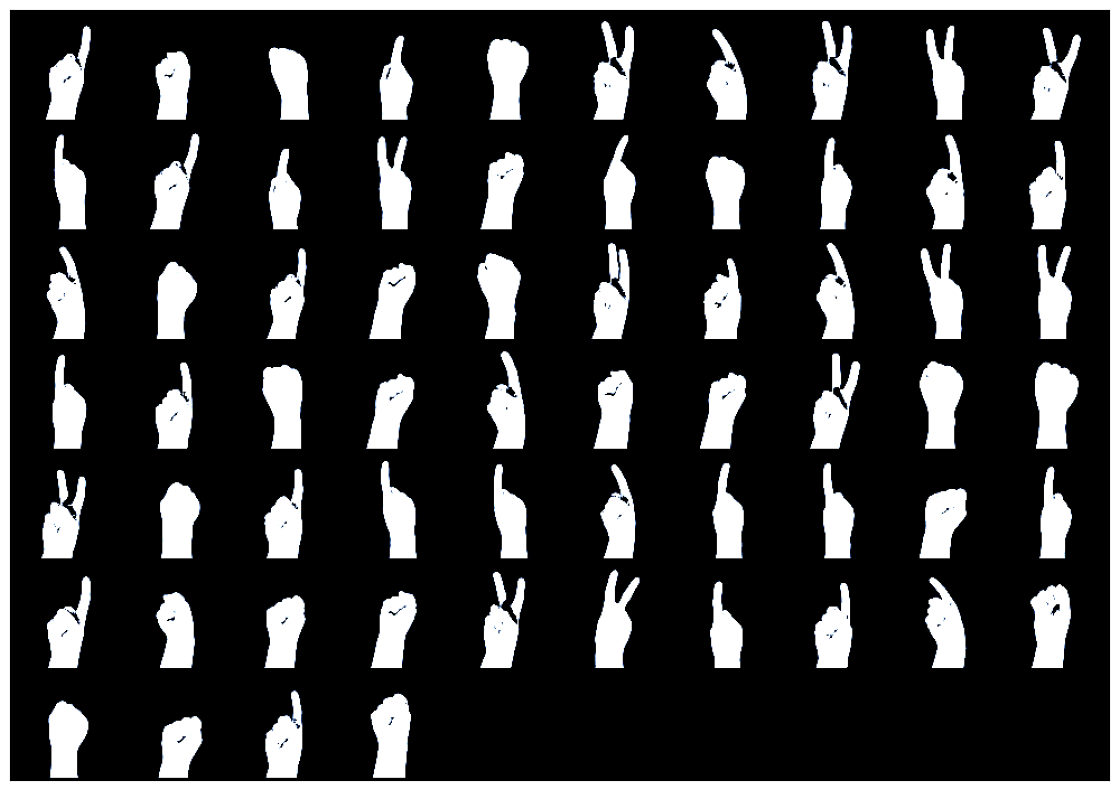

In [4]:
for images, labels in train_loader:
    fig, ax = plt.subplots(figsize=(18,10))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(images,nrow=10).permute(1,2,0))
    break

In [5]:
device = get_default_device()
train_dl = DeviceDataLoader(train_loader, device)
val_dl = DeviceDataLoader(val_loader, device)
test_dl = DeviceDataLoader(test_loader, device)
model = to_device(CnnModel(classes), device)
device

device(type='cpu')

In [6]:
history = [evaluate(model, val_loader)]

num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.001

history += fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

  0%|          | 0/81 [00:00<?, ?it/s]

Epoch [0], train_loss: 1.3603, val_loss: 0.1340, val_acc: 0.9666


  0%|          | 0/81 [00:00<?, ?it/s]

Epoch [1], train_loss: 0.1159, val_loss: 0.0023, val_acc: 1.0000


  0%|          | 0/81 [00:00<?, ?it/s]

Epoch [2], train_loss: 0.0165, val_loss: 0.0003, val_acc: 1.0000


  0%|          | 0/81 [00:00<?, ?it/s]

Epoch [3], train_loss: 0.0122, val_loss: 0.0005, val_acc: 1.0000


  0%|          | 0/81 [00:00<?, ?it/s]

Epoch [4], train_loss: 0.0120, val_loss: 0.0000, val_acc: 1.0000


  0%|          | 0/81 [00:00<?, ?it/s]

Epoch [5], train_loss: 0.0449, val_loss: 0.0533, val_acc: 0.9851


  0%|          | 0/81 [00:00<?, ?it/s]

Epoch [6], train_loss: 0.0261, val_loss: 0.0013, val_acc: 0.9986


  0%|          | 0/81 [00:00<?, ?it/s]

Epoch [7], train_loss: 0.0027, val_loss: 0.0000, val_acc: 1.0000


  0%|          | 0/81 [00:00<?, ?it/s]

Epoch [8], train_loss: 0.0012, val_loss: 0.0000, val_acc: 1.0000


  0%|          | 0/81 [00:00<?, ?it/s]

Epoch [9], train_loss: 0.1180, val_loss: 0.0003, val_acc: 1.0000


In [2]:
plot_accuracies(history)

NameError: name 'history' is not defined

In [ ]:
plot_losses(history)

In [8]:
evaluate(model, test_loader)

{'val_loss': 0.0012189962435513735, 'val_acc': 0.9992897510528564}

### Prediction and classification report

In [9]:
from sklearn.metrics import classification_report

pred = []
Y = []
for i, (x,y) in enumerate(test_loader):
    with torch.no_grad():
        outputs = model(x)
    pred += [int(op.argmax()) for op in outputs]
    Y += [int(yi) for yi in y]

print(classification_report(Y, pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       230
           1       1.00      1.00      1.00       172
           2       1.00      1.00      1.00       294
           3       1.00      1.00      1.00       212
           4       1.00      1.00      1.00       195
           5       1.00      0.99      1.00       179

    accuracy                           1.00      1282
   macro avg       1.00      1.00      1.00      1282
weighted avg       1.00      1.00      1.00      1282



In [10]:
torch.save(model, 'model.pt')